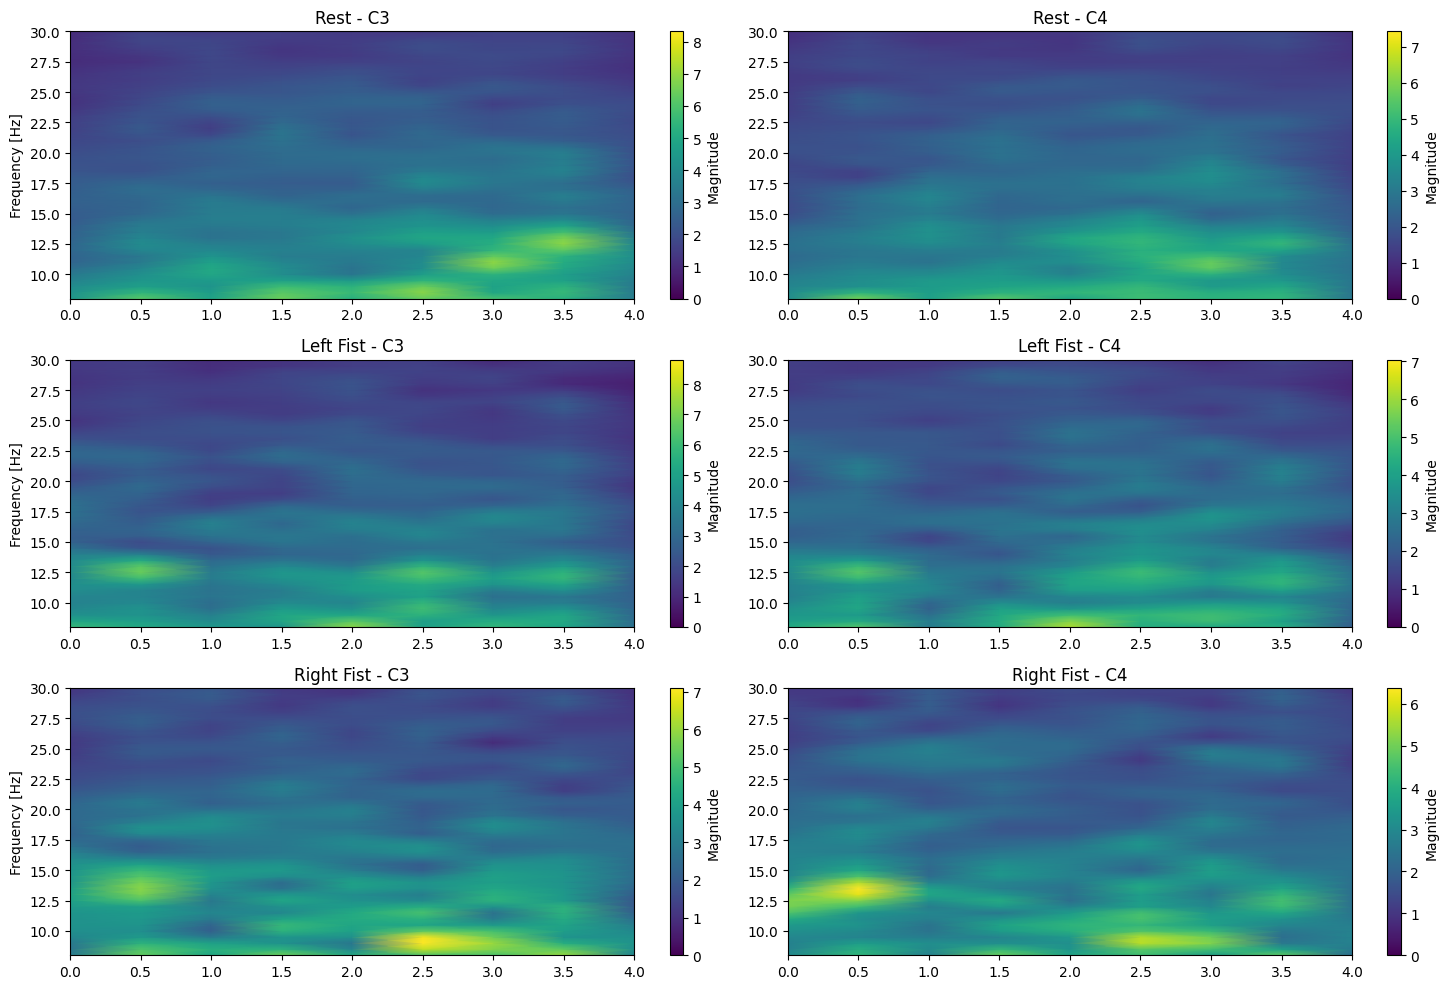

Laterality Index (Left Fist): 0.12
Laterality Index (Right Fist): 0.07


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt
from pyedflib import highlevel

# Load the EDF file
path = "S001R03.edf"
signals, signal_headers, header = highlevel.read_edf(path)
fs = signal_headers[0]['sample_frequency']  # Sampling rate (Hz)
channel_names = [h['label'] for h in signal_headers]  # List of channel names

# Find indices of C3 and C4
c3_idx = channel_names.index('C3..')
c4_idx = channel_names.index('C4..')
c3_signal = signals[c3_idx, :]
c4_signal = signals[c4_idx, :]

# Filtering functions
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def notch_filter(data, notch_freq, fs, quality=30):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = butter(2, [freq - 0.5/quality, freq + 0.5/quality], btype='bandstop')
    return filtfilt(b, a, data)

# Apply filters
c3_filtered = bandpass_filter(c3_signal, 0.5, 40, fs)
c4_filtered = bandpass_filter(c4_signal, 0.5, 40, fs)
c3_filtered = notch_filter(c3_filtered, 50, fs)
c4_filtered = notch_filter(c4_filtered, 50, fs)

# Parse annotations (manually from your description)
annotations = [
    (0.00, 4.2, 'T0'), (4.20, 4.1, 'T2'), (8.30, 4.2, 'T0'), (12.50, 4.1, 'T1'),
    (16.60, 4.2, 'T0'), (20.80, 4.1, 'T1'), (24.90, 4.2, 'T0'), (29.10, 4.1, 'T2'),
    (33.20, 4.2, 'T0'), (37.40, 4.1, 'T2'), (41.50, 4.2, 'T0'), (45.70, 4.1, 'T1'),
    (49.80, 4.2, 'T0'), (54.00, 4.1, 'T1'), (58.10, 4.2, 'T0'), (62.30, 4.1, 'T2'),
    (66.40, 4.2, 'T0'), (70.60, 4.1, 'T1'), (74.70, 4.2, 'T0'), (78.90, 4.1, 'T2'),
    (83.00, 4.2, 'T0'), (87.20, 4.1, 'T2'), (91.30, 4.2, 'T0'), (95.50, 4.1, 'T1'),
    (99.60, 4.2, 'T0'), (103.80, 4.1, 'T1'), (107.90, 4.2, 'T0'), (112.10, 4.1, 'T2'),
    (116.20, 4.2, 'T0'), (120.40, 4.1, 'T1')
]

# Convert annotations to events array (sample numbers)
events = []
for onset, duration, description in annotations:
    sample = int(onset * fs)
    events.append([sample, 0, description])

# Create event dictionary
event_dict = {'T0': 'Rest', 'T1': 'Left Fist', 'T2': 'Right Fist'}

# STFT parameters
nperseg = int(fs * 1.0)  # 1-second windows
noverlap = int(fs * 0.5)  # 50% overlap
nfft = nperseg * 2       # Zero padding

# Function to compute STFT for epochs
def compute_epoch_stft(data, events, event_type, tmin=0, tmax=4, fs=160):
    """Compute STFT for specific event type"""
    # Get all events of this type
    event_samples = [e[0] for e in events if e[2] == event_type]
    
    # Initialize list to store STFT results
    stft_results = []
    
    for sample in event_samples:
        # Extract epoch
        start = sample + int(tmin * fs)
        end = sample + int(tmax * fs)
        epoch = data[start:end]
        
        # Compute STFT
        f, t, Zxx = signal.stft(epoch, fs=fs, window='hann',
                               nperseg=nperseg, noverlap=noverlap, nfft=nfft)
        stft_results.append(np.abs(Zxx))  # Store magnitude
        
    # Average across trials
    avg_stft = np.mean(stft_results, axis=0)
    return f, t, avg_stft

# Compute STFT for each condition (C3 and C4)
conditions = ['T0', 'T1', 'T2']
results = {}

for cond in conditions:
    # C3 results
    f, t, c3_stft = compute_epoch_stft(c3_filtered, events, cond)
    # C4 results
    _, _, c4_stft = compute_epoch_stft(c4_filtered, events, cond)
    
    results[cond] = {
        'frequencies': f,
        'times': t,
        'C3': c3_stft,
        'C4': c4_stft
    }

# Visualization
plt.figure(figsize=(15, 10))

for i, cond in enumerate(conditions):
    # Plot C3
    plt.subplot(3, 2, i*2+1)
    plt.pcolormesh(results[cond]['times'], results[cond]['frequencies'], 
                  results[cond]['C3'], shading='gouraud', vmin=0, 
                  vmax=np.percentile(results[cond]['C3'], 95))
    plt.colorbar(label='Magnitude')
    plt.title(f'{event_dict[cond]} - C3')
    plt.ylabel('Frequency [Hz]')
    plt.ylim([8, 30])  # Focus on mu and beta bands
    
    # Plot C4
    plt.subplot(3, 2, i*2+2)
    plt.pcolormesh(results[cond]['times'], results[cond]['frequencies'], 
                  results[cond]['C4'], shading='gouraud', vmin=0, 
                  vmax=np.percentile(results[cond]['C4'], 95))
    plt.colorbar(label='Magnitude')
    plt.title(f'{event_dict[cond]} - C4')
    plt.ylim([8, 30])  # Focus on mu and beta bands

plt.tight_layout()
plt.show()

# Compute Laterality Index (LI) for motor imagery tasks
def laterality_index(c3_power, c4_power):
    """Compute (C3 - C4)/(C3 + C4)"""
    return (c3_power - c4_power) / (c3_power + c4_power + 1e-10)  # Small constant to avoid division by zero

# Focus on mu band (8-13 Hz) during movement (1-3s after onset)
mu_band = (results['T1']['frequencies'] >= 8) & (results['T1']['frequencies'] <= 13)
movement_window = (results['T1']['times'] >= 1) & (results['T1']['times'] <= 3)

# Compute LI for left and right fist movements
li_left = laterality_index(
    np.mean(results['T1']['C3'][mu_band][:, movement_window]),
    np.mean(results['T1']['C4'][mu_band][:, movement_window])
)

li_right = laterality_index(
    np.mean(results['T2']['C3'][mu_band][:, movement_window]),
    np.mean(results['T2']['C4'][mu_band][:, movement_window])
)

print(f"Laterality Index (Left Fist): {li_left:.2f}")
print(f"Laterality Index (Right Fist): {li_right:.2f}")

# Expected pattern:
# Left fist should show negative LI (C4 > C3)
# Right fist should show positive LI (C3 > C4)

In [2]:
import numpy as np
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def extract_features(data, events, fs, nperseg=256, noverlap=128):
    """
    Extract time-frequency features from EEG data
    Returns: X (features), y (labels), feature_names
    """
    # Frequency bands of interest
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 40)
    }
    
    # Event window parameters
    tmin, tmax = 0.5, 3.5  # Analyze 0.5-3.5s after event onset
    
    X = []
    y = []
    feature_names = []
    
    for sample, _, event_type in events:
        # Extract epoch
        start = sample + int(tmin * fs)
        end = sample + int(tmax * fs)
        epoch = data[start:end]
        
        # Compute STFT
        f, t, Zxx = signal.stft(epoch, fs=fs, window='hann',
                               nperseg=nperseg, noverlap=noverlap)
        power = np.abs(Zxx) ** 2  # Power spectrum
        
        # Initialize feature vector for this epoch
        epoch_features = []
        
        # 1. Band power features
        for band_name, (fmin, fmax) in bands.items():
            band_mask = (f >= fmin) & (f <= fmax)
            band_power = power[band_mask, :].mean(axis=0)  # Mean across frequency bins
            epoch_features.extend(band_power)
            feature_names.extend([f'{band_name}_power_{i}' for i in range(len(band_power))])
        
        # 2. Statistical features
        mean_power = power.mean(axis=1)
        std_power = power.std(axis=1)
        
        epoch_features.extend(mean_power)
        epoch_features.extend(std_power)
        feature_names.extend([f'mean_power_{i}' for i in range(len(mean_power))])
        feature_names.extend([f'std_power_{i}' for i in range(len(std_power))])
        
        X.append(epoch_features)
        y.append(event_type)
    
    return np.array(X), np.array(y), feature_names

# Extract features for C3 and C4
X_c3, y, feature_names = extract_features(c3_filtered, events, fs)
X_c4, _, _ = extract_features(c4_filtered, events, fs)

# Combine C3 and C4 features
X_combined = np.concatenate([X_c3, X_c4], axis=1)
combined_feature_names = (
    [f'C3_{name}' for name in feature_names] + 
    [f'C4_{name}' for name in feature_names]
)

# Alternative: Laterality features (C3-C4)
X_laterality = X_c3 - X_c4
laterality_feature_names = [f'Laterality_{name}' for name in feature_names]

In [3]:
# Convert labels to numerical values
label_map = {'T0': 0, 'T1': 1, 'T2': 2}
y_numeric = np.array([label_map[label] for label in y])

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_combined)

# Alternative normalization: log transform for power features
# X_normalized = np.log1p(X_combined)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

In [4]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Reduced from {X_train.shape[1]} to {X_train_pca.shape[1]} features")

Reduced from 566 to 20 features


In [5]:
def create_spectrogram_dataset(data, events, fs, nperseg=256, noverlap=128):
    """Create 3D spectrogram dataset for CNN input"""
    tmin, tmax = 0.5, 3.5  # Analysis window
    
    spectrograms = []
    labels = []
    
    for sample, _, event_type in events:
        start = sample + int(tmin * fs)
        end = sample + int(tmax * fs)
        epoch = data[start:end]
        
        f, t, Zxx = signal.stft(epoch, fs=fs, window='hann',
                               nperseg=nperseg, noverlap=noverlap)
        spectrograms.append(np.abs(Zxx))
        labels.append(label_map[event_type])
    
    # Convert to numpy arrays
    X = np.array(spectrograms)
    y = np.array(labels)
    
    # Add channel dimension (for CNN)
    X = X[..., np.newaxis]
    
    return X, y

# Create spectrogram datasets for C3 and C4
X_c3_spec, y_spec = create_spectrogram_dataset(c3_filtered, events, fs)
X_c4_spec, _ = create_spectrogram_dataset(c4_filtered, events, fs)

# Combine channels (for multi-channel CNN input)
X_combined_spec = np.stack([X_c3_spec, X_c4_spec], axis=1)  # Shape: (n_samples, 2, freq_bins, time_points, 1)

# Train-test split
X_train_spec, X_test_spec, y_train_spec, y_test_spec = train_test_split(
    X_combined_spec, y_spec, test_size=0.2, random_state=42, stratify=y_spec
)

In [7]:
from scipy.stats import skew, kurtosis  # Add this import at the top of your file

def add_time_features(X, data, events, fs):
    """Add time-domain statistical features to existing feature matrix"""
    tmin, tmax = 0.5, 3.5
    time_features = []
    
    for sample, _, _ in events:
        start = sample + int(tmin * fs)
        end = sample + int(tmax * fs)
        epoch = data[start:end]
        
        # Calculate time-domain features
        mean = np.mean(epoch)
        std = np.std(epoch)
        epoch_skew = skew(epoch)
        epoch_kurt = kurtosis(epoch)
        rms = np.sqrt(np.mean(epoch**2))  # Root Mean Square
        zero_crossings = ((epoch[:-1] * epoch[1:]) < 0).sum()  # Zero-crossing rate
        
        time_features.append([mean, std, epoch_skew, epoch_kurt, rms, zero_crossings])
    
    return np.concatenate([X, np.array(time_features)], axis=1)

# Usage
X_with_time = add_time_features(X_normalized, c3_filtered, events, fs)

In [8]:
import joblib

# Save feature-based dataset
joblib.dump({
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': combined_feature_names
}, 'eeg_features_dataset.pkl')

# Save spectrogram dataset
np.savez('eeg_spectrograms.npz',
         X_train=X_train_spec,
         X_test=X_test_spec,
         y_train=y_train_spec,
         y_test=y_test_spec)

In [10]:
import pandas as pd
print(pd.Series(y_numeric).value_counts())

0    15
1     8
2     7
Name: count, dtype: int64


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

## 1. Prepare the features (using your filtered C3 and C4 data)
def prepare_simple_features(c3_signal, c4_signal, events, fs, tmin=0.5, tmax=3.5):
    """Extract simple band power features"""
    features = []
    labels = []
    
    # Frequency bands to analyze
    bands = {
    'mu': (8, 13),
    'beta_low': (13, 20),
    'beta_high': (20, 30)
    }
    
    for sample, _, event_type in events:
        # Get epoch from both channels
        start = sample + int(tmin * fs)
        end = sample + int(tmax * fs)
        c3_epoch = c3_signal[start:end]
        c4_epoch = c4_signal[start:end]
        
        epoch_features = []
        
        # Calculate band power for each channel
        for ch_epoch in [c3_epoch, c4_epoch]:
            # Simple power spectrum (using FFT)
            fft_vals = np.fft.fft(ch_epoch)
            psd = np.abs(fft_vals) ** 2
            freqs = np.fft.fftfreq(len(ch_epoch), 1/fs)
            
            for band_name, (fmin, fmax) in bands.items():
                band_mask = (freqs >= fmin) & (freqs <= fmax)
                band_power = psd[band_mask].mean()
                epoch_features.append(band_power)
        
        # Add asymmetry feature (C3-C4)/(C3+C4) for mu band
        mu_power_c3 = epoch_features[0]  # First feature is C3 mu
        mu_power_c4 = epoch_features[2]  # Third feature is C4 mu
        asymmetry = (mu_power_c3 - mu_power_c4) / (mu_power_c3 + mu_power_c4 + 1e-10)
        epoch_features.append(asymmetry)
        
        features.append(epoch_features)
        labels.append(event_type)
    
    return np.array(features), np.array(labels)

# Extract features
X, y = prepare_simple_features(c3_filtered, c4_filtered, events, fs)

# Convert labels to numbers
label_map = {'T0': 0, 'T1': 1, 'T2': 2}
y_numeric = np.array([label_map[label] for label in y])

## 2. Preprocess and split data
# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

## 3. Train a simple Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

## 4. Evaluate the model
y_pred = model.predict(X_test)

print("Test Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Rest', 'Left Fist', 'Right Fist']))

## 5. Feature Importance
feature_names = [
    'C3_mu_power', 'C3_beta_power',
    'C4_mu_power', 'C4_beta_power',
    'Mu_asymmetry'
]

print("\nFeature Importances:")
for name, importance in zip(feature_names, model.feature_importances_):
    print(f"{name}: {importance:.3f}")

Test Accuracy: 50.00%

Classification Report:
              precision    recall  f1-score   support

        Rest       0.50      0.67      0.57         3
   Left Fist       0.00      0.00      0.00         2
  Right Fist       0.50      1.00      0.67         1

    accuracy                           0.50         6
   macro avg       0.33      0.56      0.41         6
weighted avg       0.33      0.50      0.40         6


Feature Importances:
C3_mu_power: 0.143
C3_beta_power: 0.151
C4_mu_power: 0.197
C4_beta_power: 0.108
Mu_asymmetry: 0.170


c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [10]:
#TREINAMENDO REDE NEURAL SIMPLES
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import to_categorical  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


## 1. Prepare the features (using your filtered C3 and C4 data)
def prepare_simple_features(c3_signal, c4_signal, events, fs, tmin=0.5, tmax=3.5):
    """Extract simple band power features"""
    features = []
    labels = []
    
    # Frequency bands to analyze
    bands = {
    'mu': (8, 13),
    'beta_low': (13, 20),
    'beta_high': (20, 30)
    }
    
    for sample, _, event_type in events:
        # Get epoch from both channels
        start = sample + int(tmin * fs)
        end = sample + int(tmax * fs)
        c3_epoch = c3_signal[start:end]
        c4_epoch = c4_signal[start:end]
        
        epoch_features = []
        
        # Calculate band power for each channel
        for ch_epoch in [c3_epoch, c4_epoch]:
            # Simple power spectrum (using FFT)
            fft_vals = np.fft.fft(ch_epoch)
            psd = np.abs(fft_vals) ** 2
            freqs = np.fft.fftfreq(len(ch_epoch), 1/fs)
            
            for band_name, (fmin, fmax) in bands.items():
                band_mask = (freqs >= fmin) & (freqs <= fmax)
                band_power = psd[band_mask].mean()
                epoch_features.append(band_power)
        
        # Add asymmetry feature (C3-C4)/(C3+C4) for mu band
        mu_power_c3 = epoch_features[0]  # First feature is C3 mu
        mu_power_c4 = epoch_features[2]  # Third feature is C4 mu
        asymmetry = (mu_power_c3 - mu_power_c4) / (mu_power_c3 + mu_power_c4 + 1e-10)
        epoch_features.append(asymmetry)
        
        features.append(epoch_features)
        labels.append(event_type)
    
    return np.array(features), np.array(labels)

# Extract features
X, y = prepare_simple_features(c3_filtered, c4_filtered, events, fs)

# Convert labels to numeric
label_map = {'T0': 0, 'T1': 1, 'T2': 2}
y_numeric = np.array([label_map[label] for label in y])

# 2. Normalize and split
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# 3. Build a neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes: T0, T1, T2
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Train the model
history = model.fit(X_train, y_train_cat, epochs=100, batch_size=8, validation_split=0.2, verbose=1)

# 5. Evaluate
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Predict and print classification report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Rest', 'Left Fist', 'Right Fist']))

Epoch 1/100


c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.2673 - loss: 1.1410 - val_accuracy: 0.4000 - val_loss: 1.0877
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4186 - loss: 1.0285 - val_accuracy: 0.4000 - val_loss: 1.1068
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6702 - loss: 0.9689 - val_accuracy: 0.4000 - val_loss: 1.1375
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4137 - loss: 0.9773 - val_accuracy: 0.4000 - val_loss: 1.1692
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4400 - loss: 0.9993 - val_accuracy: 0.4000 - val_loss: 1.1984
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6283 - loss: 0.9537 - val_accuracy: 0.4000 - val_loss: 1.2270
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5658 - loss: 0.8842 - val_accuracy: 0.4000 - val_loss: 1.2584
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5814 - loss: 0.8743 - val_accuracy: 0.4000 - val_loss: 1.2895
Epoc

c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build a deeper model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(3, activation='softmax')  # Output layer
])

# Compile with smaller learning rate
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)


Epoch 1/100


c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.2303 - loss: 1.8699 - val_accuracy: 0.2000 - val_loss: 1.0884
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2566 - loss: 1.5199 - val_accuracy: 0.2000 - val_loss: 1.1044
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3668 - loss: 1.2934 - val_accuracy: 0.2000 - val_loss: 1.1205
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2048 - loss: 1.3529 - val_accuracy: 0.2000 - val_loss: 1.1384
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4400 - loss: 1.4045 - val_accuracy: 0.2000 - val_loss: 1.1489
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6702 - loss: 1.0951 - val_accuracy: 0.2000 - val_loss: 1.1618
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4556 - loss: 1.3383 - val_accuracy: 0.2000 - val_loss: 1.1675
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3248 - loss: 1.3455 - val_accuracy: 0.2000 - val_loss: 1.1794
Epoc

In [9]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Predict and generate report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Rest', 'Left Fist', 'Right Fist']))



Test Accuracy: 33.33%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

Classification Report:
              precision    recall  f1-score   support

        Rest       0.50      0.67      0.57         3
   Left Fist       0.00      0.00      0.00         2
  Right Fist       0.00      0.00      0.00         1

    accuracy                           0.33         6
   macro avg       0.17      0.22      0.19         6
weighted avg       0.25      0.33      0.29         6



c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

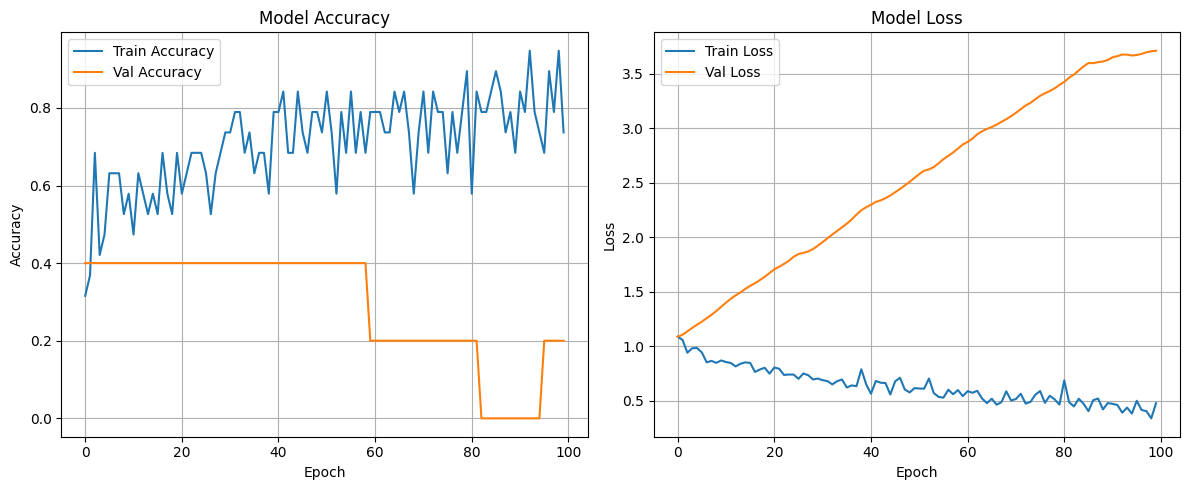

In [11]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


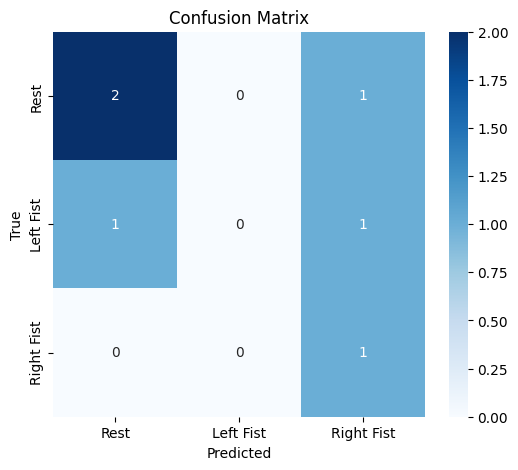

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Rest', 'Left Fist', 'Right Fist']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [22]:

# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Predict and generate report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Rest', 'Left Fist', 'Right Fist']))



Test Accuracy: 33.33%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

Classification Report:
              precision    recall  f1-score   support

        Rest       1.00      0.33      0.50         3
   Left Fist       0.00      0.00      0.00         2
  Right Fist       0.20      1.00      0.33         1

    accuracy                           0.33         6
   macro avg       0.40      0.44      0.28         6
weighted avg       0.53      0.33      0.31         6



c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luize\OneDrive\Área de Trabalho\Codes\EEG_Study\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

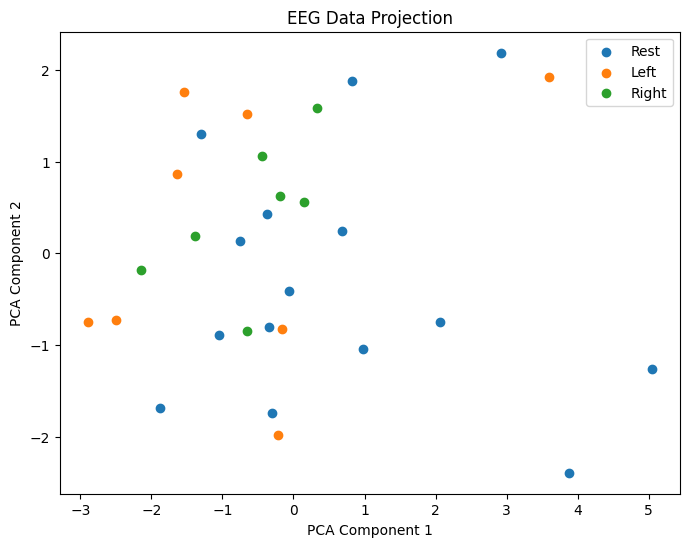

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(['Rest', 'Left', 'Right']):
    plt.scatter(X_pca[y_numeric == i, 0], X_pca[y_numeric == i, 1], label=label)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('EEG Data Projection')
plt.legend()
plt.show()